# Pandas (continues)

In [19]:
import pandas as pd
import numpy as np

## Catenating datasets

We already saw in the NumPy section how we can catenate arrays along an axis: `axis=0` catenates vertically and `axis=1` catenates horizontally, and so on. With the DataFrames of Pandas it works similarly except that the row indices and the column names require extra attention. Also note a slight difference in the name: `np.concatenate` but `pd.concat`.

Let's start by considering catenation along the axis 0, that is, vertical catenation. We will first make a helper function to easily create DataFrames for testing.

In [20]:
def makedf(cols, ind):
    data = {c : [str(c) + str(i) for i in ind] for c in cols}
    return pd.DataFrame(data, ind)

Next we will create some example DataFrames:

In [21]:
a=makedf("AB", [0,1])
a

,A,B
0,A0,B0
1,A1,B1


In [22]:
b=makedf("AB", [2,3])
b

,A,B
2,A2,B2
3,A3,B3


In [23]:
c=makedf("CD", [0,1])
c

,C,D
0,C0,D0
1,C1,D1


In [24]:
d=makedf("BC", [2,3])
d

,B,C
2,B2,C2
3,B3,C3


In the following simple case, the `concat` function works exactly as we expect it would:

In [25]:
pd.concat([a,b])   # The default axis is 0

,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


The next, however, will create duplicate indices:

In [26]:
r=pd.concat([a,a])
r

,A,B
0,A0,B0
1,A1,B1
0,A0,B0
1,A1,B1


In [27]:
r.loc[0,"A"]

0    A0
0    A0
Name: A, dtype: object

This is not usually what we want! There are three solutions to this. Firstly, deny creation of duplicated indices by giving the `verify_integrity` parameter to the `concat` function:

In [28]:
try:
    pd.concat([a,a], verify_integrity=True)
except ValueError as e:
    import sys
    print(e, file=sys.stderr)

Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


Secondly, we can ask for automatic renumbering of rows:

In [29]:
pd.concat([a,a], ignore_index=True)

,A,B
0,A0,B0
1,A1,B1
2,A0,B0
3,A1,B1


Thirdly, we can ask for *hierarchical indexing*. The indices can contain multiple levels, but on this course we don't consider hierarchical indices in detail. Hierarchical indices can make a two dimensional array to work like higher dimensional array.

In [30]:
r2=pd.concat([a,a], keys=['first', 'second'])
r2

A   B
first  0  A0  B0
       1  A1  B1
second 0  A0  B0
       1  A1  B1

In [31]:
r2["A"]["first"][0]

'A0'

Everything works similarly, when we want to catenate horizontally:

In [32]:
pd.concat([a,c], axis=1)

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1


We have so far assumed that when concatenating vertically the columns of both DataFrames are the same, and when joining horizontally the indices are the same. This is, however, not required:

In [33]:
pd.concat([a,d], sort=False)    # sort option is used to silence a deprecation message

,A,B,C
0,A0,B0,NaN
1,A1,B1,NaN
2,NaN,B2,C2
3,NaN,B3,C3


It expanded the non-existing cases with `NaN`s. This method is called an *outer join*, which forms the union of columns in the two DataFrames. The alternative is *inner join*, which forms the intersection of columns:

In [34]:
pd.concat([a,d], join="inner")

,B
0,B0
1,B1
2,B2
3,B3


#### <div class="alert alert-info"> Exercise 1 (split date continues)</div>

Write function `split_date_continues` that does

* read the bicycle data set
* clean the data set of columns/rows that contain only missing values
* drops the `Päivämäärä` column and replaces it with its splitted components as before

Use the `concat` function to do this. The function should return a DataFrame with 25 columns (first five related to the date and then the rest 20 conserning the measument location.

<hr/>

## Merging dataframes

Merging combines two DataFrames based on some common field.

Let's recall the earlier DataFrame about wages and ages of persons:

In [37]:
df = pd.DataFrame([[1000, "Jack", 21], [1500, "John", 29]], columns=["Wage", "Name", "Age"])
df

,Wage,Name,Age
0,1000,Jack,21
1,1500,John,29


Now, create a new DataFrame with the occupations of persons:

In [38]:
df2 = pd.DataFrame({"Name" : ["John", "Jack"], "Occupation": ["Plumber", "Carpenter"]})
df2

,Name,Occupation
0,John,Plumber
1,Jack,Carpenter


The following function call will merge the two DataFrames on their common field, and, importantly, will keep the indices *aligned*. What this means is that even though the names are listed in different order in the two frames, the merge will still give correct result.

In [39]:
pd.merge(df, df2)

,Wage,Name,Age,Occupation
0,1000,Jack,21,Carpenter
1,1500,John,29,Plumber


This was an example of a simple one-to-one merge, where the keys in the `Name` columns had 1-to-1 correspondence. Sometimes not all the keys appear in both DataFrames:

In [40]:
df3 = pd.concat([df2, pd.DataFrame({ "Name" : ["James"], "Occupation":["Painter"]})], ignore_index=True)
df3

,Name,Occupation
0,John,Plumber
1,Jack,Carpenter
2,James,Painter


In [41]:
pd.merge(df, df3)                # By default an inner join is computed

,Wage,Name,Age,Occupation
0,1000,Jack,21,Carpenter
1,1500,John,29,Plumber


In [42]:
pd.merge(df, df3, how="outer")   # Outer join

,Wage,Name,Age,Occupation
0,1000.0,Jack,21.0,Carpenter
1,1500.0,John,29.0,Plumber
2,NaN,James,NaN,Painter


Also, many-to-one and many-to-many relationships can occur in merges:

In [43]:
books = pd.DataFrame({"Title" : ["War and Peace", "Good Omens", "Good Omens"] , 
                      "Author" : ["Tolstoi", "Terry Pratchett", "Neil Gaiman"]})
books

,Title,Author
0,War and Peace,Tolstoi
1,Good Omens,Terry Pratchett
2,Good Omens,Neil Gaiman


In [44]:
collections = pd.DataFrame([["Oodi", "War and Peace"],
                           ["Oodi", "Good Omens"],
                           ["Pasila", "Good Omens"],
                           ["Kallio", "War and Peace"]], columns=["Library", "Title"])
collections

,Library,Title
0,Oodi,War and Peace
1,Oodi,Good Omens
2,Pasila,Good Omens
3,Kallio,War and Peace


All combinations with matching keys (`Name`) are created:

In [45]:
libraries_with_books_by = pd.merge(books, collections)
libraries_with_books_by

,Title,Author,Library
0,War and Peace,Tolstoi,Oodi
1,War and Peace,Tolstoi,Kallio
2,Good Omens,Terry Pratchett,Oodi
3,Good Omens,Terry Pratchett,Pasila
4,Good Omens,Neil Gaiman,Oodi
5,Good Omens,Neil Gaiman,Pasila


#### <div class="alert alert-info"> Exercise 2 (cycling weather)</div>

Merge the cycling and weather data sets along the columns year, month, and day. Note that the names of these columns might be different in the two tables. Then drop useless columns 'm', 'd', 'Time', and 'Time zone'.

Write function `cycling_weather` that reads the data sets and returns the resulting DataFrame.

<hr/>

#### <div class="alert alert-info"> Exercise 3 (top bands)</div>

Merge the DataFrames UK top40 and the bands DataFrame that are downloaded in the `src` folder (`https://www.cs.helsinki.fi/u/jttoivon/dap/data/bands.tsv`).

<hr/>

## Aggregates and groupings

Let us use again the weather dataset. First, we make the column names a bit more uniform and concise. For example the columns `Year`, `m`, and `d` are not uniformly named.

We can easily change the column names with the `rename` method of the DataFrame. Note that we cannot directly change the index `wh.columns` as it is immutable.

In [48]:
wh = pd.read_csv("https://www.cs.helsinki.fi/u/jttoivon/dap/data/fmi/kumpula-weather-2017.csv")

In [49]:
wh3 = wh.rename(columns={"m": "Month", "d": "Day", "Precipitation amount (mm)" : "Precipitation", 
                         "Snow depth (cm)" : "Snow", "Air temperature (degC)" : "Temperature"})
wh3.head()

,Year,Month,Day,Time,Time zone,Precipitation,Snow,Temperature
0,2017,1,1,00:00,UTC,-1.0,-1.0,0.6
1,2017,1,2,00:00,UTC,4.4,-1.0,-3.9
2,2017,1,3,00:00,UTC,6.6,7.0,-6.5
3,2017,1,4,00:00,UTC,-1.0,13.0,-12.8
4,2017,1,5,00:00,UTC,-1.0,10.0,-17.8


Pandas has an operation that splits a DataFrame into groups, performs some operation on each of the groups, and then combines the result from each group into a resulting DataFrame. This split-apply-combine functionality is really flexible and powerful operation. In Pandas you start by calling the `groupby` method, which splits the DataFrame into groups. In the following example the rows that contain measurements from the same month belong to the same group:

In [50]:
groups = wh3.groupby("Month")
groups

Nothing happened yet, but the `groupby` object knows how the division into groups is done. This is called a lazy operation. We can query the number of groups in the `groupby` object:

In [51]:
len(groups)

12

We can iterate through all the groups:

In [52]:
for key, group in groups:
    print(key, len(group))

1 31
2 28
3 31
4 30
5 31
6 30
7 31
8 31
9 30
10 31
11 30
12 31


In [53]:
groups.get_group(2)                 # Group with index two is February

,Year,Month,Day,Time,Time zone,Precipitation,Snow,Temperature
31,2017,2,1,00:00,UTC,1.5,4.0,-0.6
32,2017,2,2,00:00,UTC,0.2,5.0,-0.8
33,2017,2,3,00:00,UTC,-1.0,6.0,-0.2
34,2017,2,4,00:00,UTC,2.7,6.0,0.4
35,2017,2,5,00:00,UTC,-1.0,7.0,-2.5
36,2017,2,6,00:00,UTC,-1.0,7.0,-7.3
37,2017,2,7,00:00,UTC,-1.0,8.0,-12.1
38,2017,2,8,00:00,UTC,-1.0,8.0,-8.8
39,2017,2,9,00:00,UTC,-1.0,8.0,-10.1
40,2017,2,10,00:00,UTC,-1.0,8.0,-8.3


The `groupby` object functions a bit like a DataFrame, so some operations which are allowed for DataFrames are also allowed for the `groupby` object. For example, we can get a subset of columns:

In [54]:
groups["Temperature"]

For each DataFrame corresponding to a group the Temperature column was chosen. Still nothing was shown, because we haven't applied any operation on the groups.

The common methods also include the aggregation methods. Let's try to apply the `mean` aggregation:

In [55]:
groups["Temperature"].mean()

Month
1     -2.316129
2     -2.389286
3      0.983871
4      2.676667
5      9.783871
6     13.726667
7     16.035484
8     16.183871
9     11.826667
10     5.454839
11     3.950000
12     1.741935
Name: Temperature, dtype: float64

Now what happened was that after the mean aggregation was performed on each group, the results were automatically combined into a resulting DataFrame. Let's try some other aggregation:

In [56]:
groups["Precipitation"].sum()

Month
1      26.9
2      21.0
3      29.7
4      26.9
5      -5.9
6      59.3
7      14.2
8      70.1
9      51.2
10    173.5
11    117.2
12    133.6
Name: Precipitation, dtype: float64

Ok, the -1.0 values in the Precipitation field are causing trouble here, let's convert them to zeros:

In [57]:
wh4 = wh3.copy()
wh4.loc[wh4.Precipitation == -1, "Precipitation"] = 0
wh4.loc[wh4.Snow == -1, "Snow"] = 0
wh4.head()

,Year,Month,Day,Time,Time zone,Precipitation,Snow,Temperature
0,2017,1,1,00:00,UTC,0.0,0.0,0.6
1,2017,1,2,00:00,UTC,4.4,0.0,-3.9
2,2017,1,3,00:00,UTC,6.6,7.0,-6.5
3,2017,1,4,00:00,UTC,0.0,13.0,-12.8
4,2017,1,5,00:00,UTC,0.0,10.0,-17.8


In [58]:
wh4.groupby("Month")["Precipitation"].sum()

Month
1      38.9
2      35.0
3      41.7
4      39.9
5      16.1
6      76.3
7      31.2
8      86.1
9      65.2
10    184.5
11    120.2
12    140.6
Name: Precipitation, dtype: float64

### Other ways to operate on groups

The aggregations are not the only possible operations on groups. The other possibilities are filtering, transformation, and application.

In **filtering** some of the groups can be filtered out.

In [59]:
def myfilter(df):                                     # The filter function must return a boolean value
    return df["Precipitation"].sum() >= 150

wh4.groupby("Month").filter(myfilter)                 # Filter out months with total precipitation less that 150 mm

,Year,Month,Day,Time,Time zone,Precipitation,Snow,Temperature
273,2017,10,1,00:00,UTC,0.0,0.0,9.1
274,2017,10,2,00:00,UTC,6.4,0.0,9.2
275,2017,10,3,00:00,UTC,21.5,0.0,8.3
276,2017,10,4,00:00,UTC,12.7,0.0,11.2
277,2017,10,5,00:00,UTC,0.6,0.0,8.8
278,2017,10,6,00:00,UTC,0.7,0.0,7.7
279,2017,10,7,00:00,UTC,11.7,0.0,8.1
280,2017,10,8,00:00,UTC,14.1,0.0,9.3
281,2017,10,9,00:00,UTC,18.3,0.0,8.6
282,2017,10,10,00:00,UTC,24.2,0.0,8.1


In a **transformation** each group's DataFrame is manipulated in a way that retains its shape. An example of centering values, so that the deviations from the monthly means are shown:

In [60]:
pd.concat([wh4.iloc[:, 0:3], 
           wh4.groupby("Month")[["Precipitation", "Snow", "Temperature"]].transform(lambda x : x - x.mean())], 
          axis=1)

,Year,Month,Day,Precipitation,Snow,Temperature
0,2017,1,1,-1.254839,-6.903226,2.916129
1,2017,1,2,3.145161,-6.903226,-1.583871
2,2017,1,3,5.345161,0.096774,-4.183871
3,2017,1,4,-1.254839,6.096774,-10.483871
4,2017,1,5,-1.254839,3.096774,-15.483871
5,2017,1,6,-0.954839,3.096774,-15.483871
6,2017,1,7,4.045161,3.096774,-1.483871
7,2017,1,8,-1.254839,5.096774,1.816129
8,2017,1,9,-0.154839,5.096774,2.816129
9,2017,1,10,-0.954839,2.096774,4.016129


The **apply** method is very generic and only requires that for each group's DataFrame the given function returns a DataFrame, Series, or a scalar. In the following example, we sort within each group by the temperature:

In [61]:
wh4.groupby("Month").apply(lambda df : df.sort_values("Temperature"))

Year  Month  Day   Time Time zone  Precipitation  Snow  Temperature
Month                                                                         
1     4    2017      1    5  00:00       UTC            0.0  10.0        -17.8
      5    2017      1    6  00:00       UTC            0.3  10.0        -17.8
      3    2017      1    4  00:00       UTC            0.0  13.0        -12.8
      2    2017      1    3  00:00       UTC            6.6   7.0         -6.5
      15   2017      1   16  00:00       UTC            0.0   8.0         -4.2
      1    2017      1    2  00:00       UTC            4.4   0.0         -3.9
      24   2017      1   25  00:00       UTC            0.6   6.0         -3.8
      6    2017      1    7  00:00       UTC            5.3  10.0         -3.8
      16   2017      1   17  00:00       UTC            0.2   8.0         -3.5
      11   2017      1   12  00:00       UTC            8.0   7.0         -2.8
      14   2017      1   15  00:00       UTC            0.0   8.0         -2.8
      23   2017      1   24  00:00       UTC            0.0   6.0         -2.2
      20   2017      1   21  00:00       UTC            0.4   5.0         -1.8
      10   2017      1   11  00:00       UTC            0.0   7.0         -1.6
      19   2017      1   20  00:00       UTC            0.3   5.0         -0.6
      7    2017      1    8  00:00       UTC            0.0  12.0         -0.5
      22   2017      1   23  00:00       UTC            0.1   6.0          0.1
      30   2017      1   31  00:00       UTC            0.0   4.0          0.2
      8    2017      1    9  00:00       UTC            1.1  12.0          0.5
      28   2017      1   29  00:00       UTC            2.6   3.0          0.6
      0    2017      1    1  00:00       UTC            0.0   0.0          0.6
      13   2017      1   14  00:00       UTC            0.1   8.0          0.8
      27   2017      1   28  00:00       UTC            1.8   4.0          0.8
      29   2017      1   30  00:00       UTC            5.6   5.0          1.0
      21   2017      1   22  00:00       UTC            0.2   5.0          1.0
      12   2017      1   13  00:00       UTC            0.1  13.0          1.1
      17   2017      1   18  00:00       UTC            0.9   8.0          1.1
      18   2017      1   19  00:00       UTC            0.0   5.0          1.6
      26   2017      1   27  00:00       UTC            0.0   4.0          1.6
      9    2017      1   10  00:00       UTC            0.3   9.0          1.7
...         ...    ...  ...    ...       ...            ...   ...          ...
12    340  2017     12    7  00:00       UTC           16.3   0.0         -0.8
      357  2017     12   24  00:00       UTC            0.0   0.0         -0.3
      355  2017     12   22  00:00       UTC            0.0   0.0         -0.1
      338  2017     12    5  00:00       UTC            0.7   0.0          0.0
      350  2017     12   17  00:00       UTC            0.0   5.0          0.1
      358  2017     12   25  00:00       UTC            5.9   0.0          0.3
      334  2017     12    1  00:00       UTC            3.4   0.0          0.9
      352  2017     12   19  00:00       UTC            0.2   3.0          1.0
      356  2017     12   23  00:00       UTC            7.6   0.0          1.2
      337  2017     12    4  00:00       UTC            0.0   0.0          1.3
      335  2017     12    2  00:00       UTC            5.3   5.0          1.4
      344  2017     12   11  00:00       UTC            1.3   0.0          1.4
      364  2017     12   31  00:00       UTC            3.2   0.0          1.6
      346  2017     12   13  00:00       UTC            4.2   5.0          1.6
      345  2017     12   12  00:00       UTC           35.0   0.0          1.6
      347  2017     12   14  00:00       UTC            5.2   4.0          1.6
      348  2017     12   15  00:00       UTC           10.0  10.0          1.7
      359  2017     12   26  00:00       UTC            7.8  

#### <div class="alert alert-info"> Exercise 4 (cyclists per day)</div>

Read, clean and parse the bicycle data set as usual. Group the rows by year, month, and day. Get the sum for each group.

Part 1.

Make function `cyclists_per_day` that does the above. The function should return a DataFrame.

Part 2.

In the `main` function, using the function `cyclists_per_day`, get the daily counts. Drop the columns Hour and Weekday. The index of the DataFrame now consists of tuples (Year, Month, Day). Then restrict this data to August of year 2017, and plot this data. Don't forget to call the `plt.show` function of matplotlib. The x-axis should have ticks from 1 to 31, and there should be a curve to each measuring station. Can you spot the weekends?

<hr/>

#### <div class="alert alert-info"> Exercise 5 (best record company)</div>

We use again the UK top 40 data set from the first week of 1964 in the `src` folder (https://www.cs.helsinki.fi/u/jttoivon/dap/data/UK-top40-1964-1-2.tsv ). Here we define "goodness" of a record company (`Publisher`) based on the sum of the weeks of chart (WoC) of its singles. Return a DataFrame of the singles by the best record company (a subset of rows of the original DataFrame). Do this with function `best_record_company`.

<hr/>

#### <div class="alert alert-info"> Exercise 6 (suicide fractions)</div>

Load the suicide data set from `src` folder (https://www.cs.helsinki.fi/u/jttoivon/dap/data/kaggle/who_suicide_statistics.csv) . This data was originally downloaded from [Kaggle](https://www.kaggle.com/szamil/who-suicide-statistics). Kaggle contains lots of interesting open data sets.

Write function `suicide_fractions` that loads the data set and returns a Series that has the country as the (row) index and as the column the fraction of suicides per population in that country. In more detail, this fraction is the average of suicide fractions. The information about year, sex and age is not used.

<hr/>

#### <div class="alert alert-info"> Exercise 7 (suicide weather)</div>

Copy the function `suicide fractions` from the previous exercise. Also download the dataset of average temperature (over years 1961-1990) in different countries from `src/List_of_countries_by_average_yearly_temperature.html` (https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature) .
You can use the function `pd.read_html` to get all the tables from a html page. By default `pd.read_html` does not know which row contain column header and which column contains row headers. Maku sure you use the country as the (row) index for both of the DataFrames. What is the [Spearman correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between these variables? Use the `corr` method of Series object. Note the the two Series need not be sorted as the indices of the rows (country names) are used to align them.

The return value of the function is a tuple (suicide_rows, temperature_rows, common_rows, spearman_correlation)
The output from the `main` function should be of the following form:

```
Suicide DataFrame has x rows
Temperature DataFrame has x rows
Common DataFrame has x rows
Spearman correlation: x.x
```

You might have trouble when trying to convert the temperatures to float. The is because the negative numbers on that html page use a special *unicode minus sign*, which looks typographically nice, but the float constructor cannot interpret it as a minus sign. You can try out the following example:

In [62]:
s="\u22125"
print(s)
try:
    float(s)
except ValueError as e:
    import sys
    print(e, file=sys.stderr)
        

−5


could not convert string to float: '−5'


But if we explicitly convert unicode minus sign to normal minus sign, it works:

In [63]:
float(s.replace("\u2212", "-"))

-5.0

<hr/>

## Time series

Let's make a copy of the DataFrame that we can mess with:

In [64]:
wh2 = wh3.copy()
wh2.columns

Index(['Year', 'Month', 'Day', 'Time', 'Time zone', 'Precipitation', 'Snow',
       'Temperature'],
      dtype='object')

The column names `Year`, `Month`, and `Day` are now in appropriate form for the `to_datetime` function. It can convert these fields into a timestamp series, which we will add to the DataFrame.

In [65]:
wh2["Date"] = pd.to_datetime(wh2[["Year", "Month", "Day"]])
wh2.head()

,Year,Month,Day,Time,Time zone,Precipitation,Snow,Temperature,Date
0,2017,1,1,00:00,UTC,-1.0,-1.0,0.6,2017-01-01
1,2017,1,2,00:00,UTC,4.4,-1.0,-3.9,2017-01-02
2,2017,1,3,00:00,UTC,6.6,7.0,-6.5,2017-01-03
3,2017,1,4,00:00,UTC,-1.0,13.0,-12.8,2017-01-04
4,2017,1,5,00:00,UTC,-1.0,10.0,-17.8,2017-01-05


We can now drop the useless fields:

In [66]:
wh2=wh2.drop(columns=["Year", "Month", "Day"])
wh2.head()

,Time,Time zone,Precipitation,Snow,Temperature,Date
0,00:00,UTC,-1.0,-1.0,0.6,2017-01-01
1,00:00,UTC,4.4,-1.0,-3.9,2017-01-02
2,00:00,UTC,6.6,7.0,-6.5,2017-01-03
3,00:00,UTC,-1.0,13.0,-12.8,2017-01-04
4,00:00,UTC,-1.0,10.0,-17.8,2017-01-05


The following method call will set the Date field as the index of the DataFrame.

In [67]:
wh2 = wh2.set_index("Date")
wh2.head()

,Time,Time zone,Precipitation,Snow,Temperature
Date,,,,,
2017-01-01,00:00,UTC,-1.0,-1.0,0.6
2017-01-02,00:00,UTC,4.4,-1.0,-3.9
2017-01-03,00:00,UTC,6.6,7.0,-6.5
2017-01-04,00:00,UTC,-1.0,13.0,-12.8
2017-01-05,00:00,UTC,-1.0,10.0,-17.8


We can now easily get a set of rows using date slices:

In [68]:
wh2["2017-01-15":"2017-02-03"]

,Time,Time zone,Precipitation,Snow,Temperature
Date,,,,,
2017-01-15,00:00,UTC,-1.0,8.0,-2.8
2017-01-16,00:00,UTC,-1.0,8.0,-4.2
2017-01-17,00:00,UTC,0.2,8.0,-3.5
2017-01-18,00:00,UTC,0.9,8.0,1.1
2017-01-19,00:00,UTC,-1.0,5.0,1.6
2017-01-20,00:00,UTC,0.3,5.0,-0.6
2017-01-21,00:00,UTC,0.4,5.0,-1.8
2017-01-22,00:00,UTC,0.2,5.0,1.0
2017-01-23,00:00,UTC,0.1,6.0,0.1


By using the `date_range` function even more complicated sets can be formed. The following gets all the Mondays of July:

In [69]:
r=pd.date_range("2017-07-01", "2017-07-31", freq="w-mon")
r

DatetimeIndex(['2017-07-03', '2017-07-10', '2017-07-17', '2017-07-24',
               '2017-07-31'],
              dtype='datetime64[ns]', freq='W-MON')

In [70]:
wh2.index.difference(r)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=360, freq=None)

In [71]:
wh2.loc[r,:]

,Time,Time zone,Precipitation,Snow,Temperature
2017-07-03,00:00,UTC,2.2,-1.0,14.5
2017-07-10,00:00,UTC,-1.0,-1.0,18.0
2017-07-17,00:00,UTC,2.7,-1.0,15.4
2017-07-24,00:00,UTC,-1.0,-1.0,15.7
2017-07-31,00:00,UTC,0.1,-1.0,17.8


The following finds all the business days (Monday to Friday) of July:

In [72]:
pd.date_range("2017-07-01", "2017-07-31", freq="b")

DatetimeIndex(['2017-07-03', '2017-07-04', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14', '2017-07-17', '2017-07-18',
               '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-31'],
              dtype='datetime64[ns]', freq='B')

We can get a general idea about the `Temperature` column by plotting it. Note how the index time series is shown nicely on the x-axis.

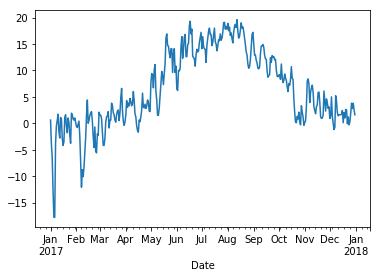

In [73]:
%matplotlib inline
wh2["Temperature"].plot();

The graph looks a bit messy at this level of detail. We can smooth it by taking averages over a sliding window of length 30 days:

In [74]:
rolling = wh2.Temperature.rolling(30, center=True)
rolling

Rolling [window=30,center=True,axis=0]

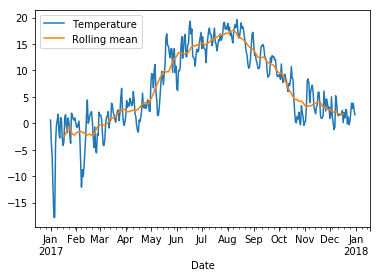

In [75]:
data = pd.DataFrame({"Temperature" : wh2.Temperature, "Rolling mean" : rolling.mean()})
data.plot();

#### <div class="alert alert-info"> Exercise 8 (bicycle timeseries)</div>

Write function `bicycle_timeseries` that

* reads the data set
* cleans it
* turns its `Päivämäärä` column into (row) DatetimeIndex (that is, to row names)
* returns the new DataFrame

<hr/>

#### <div class="alert alert-info"> Exercise 9 (commute)</div>

In function `commute` do the following:

Use the function `bicycle_timeseries` to get the bicycle data. Restrict to August 2017, group by the weekday, aggregate by summing. Set the `Weekday` column to numbers from one to seven. Then set the column `Weekday` as the (row) index. Return the resulting DataFrame from the function.

In the `main` function plot the DataFrame. Xticklabels should be the weekdays. Don't forget to call `show` function!

If you want the xticklabels to be `['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun']` instead of numbers, then it may get a bit messy. There seems to be a problem with non-numeric `x` values. You could try the following after plotting, but you don't have to:

```python
weekdays="x mon tue wed thu fri sat sun".title().split()
plt.gca().set_xticklabels(weekdays)
```

<hr/>

## Additional information

[Pandas cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) Summary of most important Pandas' functions and methods.

Read the article [Tidy Data](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf). The article uses the statistical software R as an example, but the ideas are relevant in general. Pandas operations maintain data in the tidy format.

Pandas handles only one dimensional data (Series) and two dimensional data (DataFrame). While you can use [hierarchical indices](http://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#hierarchical-indexing-multiindex) to simulate higher dimensional arrays, you should use the [xarray](http://xarray.pydata.org/en/stable/index.html) library, if you need proper higher-dimensional arrays with labels. It is basically a cross between NumPy and Pandas.

